<a href="https://colab.research.google.com/github/shakir507/BacklogModels/blob/main/DemandSurgeModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this code we will demonstrate demand surge toy examples. These toy models include a square wave, a convoluted square wave and a sine wave, a convoluted square wave with a SIR curve.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [56]:

# Parameters
T0 = 1  # Initial time
Tf = 200  # Final time
time_span = (T0, Tf)  # Time range for simulation
time_points_backlog = np.linspace(time_span[0], time_span[1], 10000)  # Time points for evaluation
demandsurge = 600
period = 90  # Period of the surge
t1 = 50  # Start of the surge
t2 = t1 + period  # End of the surge

# Counting number of time points between t1 and t2 based on time_points_backlog
timepoints_t1_t2 = time_points_backlog[(time_points_backlog >= t1) & (time_points_backlog <= t2)]
print("Number of time points between t1 and t2:", len(timepoints_t1_t2))
time_points_SIR = np.linspace(t1, t2, len(timepoints_t1_t2))  # Time points for evaluation


Number of time points between t1 and t2: 4522


In [57]:

# Parameters for the SIR model
beta = 0.6  # Infection rate
gamma = 0.4  # Recovery rate
Ntot=10000 #Total population


In [58]:

# Define the time-dependent growth rate a(t)
def STEP(a0, t, t0):
    return a0 * np.heaviside(t - t0, 0)

In [59]:

def SIR(t, Y, beta, gamma):
    S, I, R = Y
    dS_dt = -beta * S * I
    dI_dt = beta * S * I - gamma * I
    dR_dt = gamma * I
    return [dS_dt, dI_dt, dR_dt]


def solve_SIR(t1, t2, period):
    # Parameters
    time_span = (0, t2 - t1)  # Time span for simulation
    time_points = np.linspace(time_span[0], time_span[1], 1000)  # Time points for evaluation
    # Initial conditions
    S0 = 1-1/Ntot  # Initial susceptible population
    I0 = 1/Ntot # Initial infected population
    R0 = 0.0  # Initial recovered population
    Initial_conditions = [S0, I0, R0]
    # Solve the ODE
    solution = solve_ivp(
        SIR,                   # ODE function
        time_span,             # Time span
        Initial_conditions,    # Initial condition
        t_eval=time_points,    # Time points to evaluate the solution
        args=(beta, gamma),    # Additional arguments for the ODE function
        rtol=1e-6,             # Relative tolerance
        atol=1e-6              # Absolute tolerance
    )
    solution.y[1]*=Ntot
    # Create an interpolator for the infected population (I)
    interpolate_infected = interp1d(
        solution.t + t1,  # Shift time back to t1 -> t2 range
        solution.y[1],    # Infected population
        kind='linear',
        fill_value="extrapolate"
    )
    return interpolate_infected


def demandsurge_function(fn=1):
    if fn == 1 or fn == 2:
        return demandsurge
    if fn == 3:
        SIR_interpolator = solve_SIR(t1, t2, period)  # Get the interpolator
        return SIR_interpolator(time_points_backlog)  # Evaluate for all time points


In [60]:

def demand(t, delta, fn=1):
    if fn == 1:
        return 100 + STEP(delta, t, t1) - STEP(delta, t, t1 + period)  # Square wave
    if fn == 2:
        return 100 + (1 + delta * np.sin(2 * np.pi * (t - t1) / (2 * period))) * STEP(1, t, t1) - STEP(1, t, t1 + period) * (1 + delta * np.sin(2 * np.pi * (t - t1) / (2 * period)))  # Sinusoidal
    if fn == 3:
        SIR_I_at_t = delta  # `delta` is the array from demandsurge_function(fn=3)
        return np.where(t < t1, 100, np.where(t > t2, 100, 100 + SIR_I_at_t * (STEP(1, t, t1) - STEP(1, t, t1 + period))))  # SIR-based


Text(0.5, 1.0, 'Demand Surge Based on SIR Dynamics')

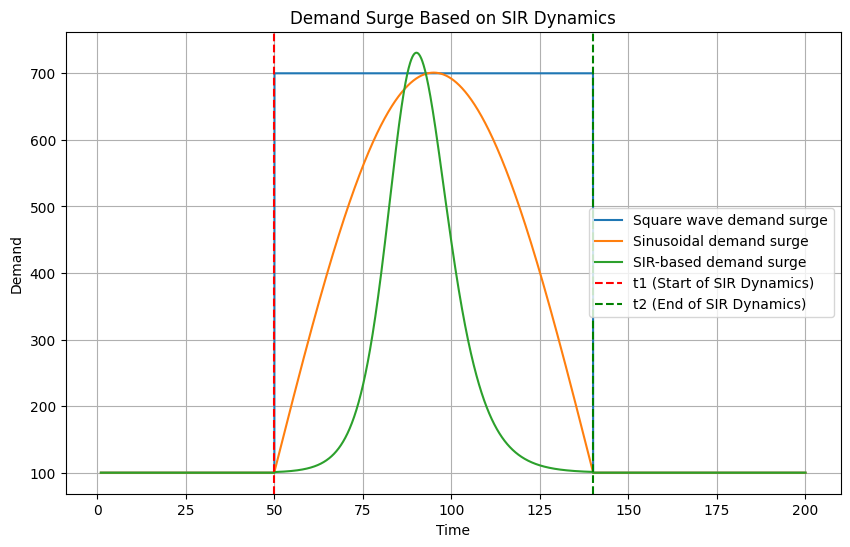

In [61]:

# Plot the demand surge
plt.figure(figsize=(10, 6))
plt.plot(time_points_backlog, demand(time_points_backlog, demandsurge_function(fn=1),fn=1), label='Square wave demand surge')
plt.plot(time_points_backlog, demand(time_points_backlog, demandsurge_function(fn=2), fn=2), label='Sinusoidal demand surge')
plt.plot(time_points_backlog, demand(time_points_backlog, demandsurge_function(fn=3), fn=3), label='SIR-based demand surge')
plt.axvline(t1, color='red', linestyle='--', label='t1 (Start of SIR Dynamics)')
plt.axvline(t2, color='green', linestyle='--', label='t2 (End of SIR Dynamics)')
plt.xlabel('Time')
plt.ylabel('Demand')
plt.legend()
plt.grid()
plt.title('Demand Surge Based on SIR Dynamics')
